# Options Trading Application

---

**Date:** 2025-05-12
**Author:** Gandhar, Julia

---

## Content
This notebook applies AdaptiveIS to an options trading dataset downloaded from Kaggle (https://www.kaggle.com/datasets/muhammadanas0716/tradyflow-options-trading).  

# Background

## What is the goal for options pricing?

The fundamental goal in options pricing is to determine a **fair value** for an option based on the probability distribution of the underlying asset’s price at expiration. In the risk-neutral framework, the price of a European-style option is the **discounted expected value of its payoff** under the risk-neutral measure $ \mathbb{Q} $.

### For a **call option**:

$$
\text{Call Price} = e^{-rT} \, \mathbb{E}_{\mathbb{Q}} \left[ \max(S_T - K, 0) \right]
$$

### For a **put option**:

$$
\text{Put Price} = e^{-rT} \, \mathbb{E}_{\mathbb{Q}} \left[ \max(K - S_T, 0) \right]
$$

- $S_T$: Price of the underlying asset at option expiry  
- $K$: Strike price  
- $r$: Risk-free interest rate  
- $T$: Time to maturity in years  
- $\mathbb{E}_{\mathbb{Q}}$: Expectation under the risk-neutral measure  

When closed-form solutions like Black-Scholes are not appropriate (e.g., with path-dependent or exotic payoffs), **Monte Carlo simulation** methods are often used instead.

---

## What are the main parameters involved?

Here are the key parameters used in Monte Carlo AIS for options pricing:

### Market/Input Parameters:
| Symbol | Name | Description |
|--------|------|-------------|
| $S_0$ | Spot Price | Current price of the underlying asset |
| $K$ | Strike Price | Strike at which the option can be exercised |
| $T$ | Time to Maturity | Time until expiration (in years) |
| $r$ | Risk-Free Rate | Constant rate used for discounting |
| Option Type | Call/Put | Determines payoff structure: $\max(S_T - K, 0)$ or $\max(K - S_T, 0)$ |
| $\sigma$ | **Implied Volatility** | Market-implied expected volatility (inferred from prices) |

---

### How is Volatility ($\sigma$) calculated?

In your dataset, volatility is not directly given — it's **inferred** from the market prices of options. This is known as **implied volatility**.

Implied volatility is the value of $\sigma$ that, when plugged into the Black-Scholes formula, yields the observed option price (market premium). Mathematically, it's the **solution to the inverse problem**:

$$
f(\sigma) = \text{BS}_{\text{model}}(S_0, K, T, r, \sigma) - \text{Market Price} = 0
$$


That is, we solve for $\sigma$ such that:

- For calls:
  $$
  C_{\text{market}} = S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2)
  $$

- For puts:
  $$
  P_{\text{market}} = K e^{-rT} \Phi(-d_2) - S_0 \Phi(-d_1)
  $$

Where:
- $d_1 = \frac{\ln(S_0 / K) + (r + \frac{\sigma^2}{2})T}{\sigma \sqrt{T}}$
- $d_2 = d_1 - \sigma \sqrt{T}$

Since this equation cannot be solved analytically for $\sigma$, a **numerical root-finding algorithm** (like the Brent method or Newton-Raphson) is used.

---

## Why use AIS?

**Adaptive Importance Sampling (AIS)** is a variance-reduction technique used to improve the efficiency and accuracy of Monte Carlo methods, particularly in high-variance or rare-event scenarios common in options pricing.

### Problems with standard Monte Carlo:
- Inefficient sampling: many simulations result in zero payoff contributions (e.g., deep out-of-the-money options).
- High variance in estimates.

### AIS addresses this by:
- **Biasing the sampling distribution** toward regions that contribute most to the payoff (e.g., regions where options expire in-the-money).
- **Re-weighting samples** to maintain unbiasedness.
- **Adapting** the proposal distribution iteratively to improve convergence.

### Importance sampling reformulation:

We rewrite the original expectation:

$$
\mathbb{E}_{p(z)}[f(z)] = \int f(z) p(z) \, dz = \int \frac{f(z) p(z)}{q(z)} q(z) \, dz = \mathbb{E}_{q(z)}\left[ \frac{f(z) p(z)}{q(z)} \right]
$$

In AIS:
- $f(z)$: Payoff function, e.g., $\max(S_T - K, 0)$  
- $p(z)$: Target distribution (e.g., standard normal $\mathcal{N}(0, 1)$)  
- $q(z)$: Adaptive **proposal distribution** (biased distribution used to sample $z$)  
- $\frac{p(z)}{q(z)}$: **Importance weight**, corrects for bias in the proposal  

As the AIS procedure evolves, it **updates the parameters** (mean and variance) of the proposal distribution $q(z; \mu, \sigma^2)$ at each iteration to focus sampling more efficiently.

---

## What are the main parameters involved?

Here are the key parameters used in Monte Carlo AIS for options pricing:

### Market/Input Parameters:
| Symbol | Name | Description |
|--------|------|-------------|
| $S_0$ | Spot Price | Current price of the underlying asset |
| $K$ | Strike Price | Strike at which the option can be exercised |
| $T$ | Time to Maturity | Time until expiration (in years) |
| $\sigma$ | Volatility | Typically implied from market data |
| $r$ | Risk-Free Rate | Constant rate used for discounting |
| Option Type | Call/Put | Determines payoff structure: $\max(S_T - K, 0)$ or $\max(K - S_T, 0)$ |

### AIS Algorithm Parameters:
| Variable | Description |
|----------|-------------|
| $N$ | Number of Monte Carlo samples per iteration |
| $\mu$ | Mean of proposal distribution $q(z; \mu, \sigma^2)$ |
| $\sigma_{\text{prop}}$ | Standard deviation of the proposal distribution |
| `max_iter` | Maximum number of AIS iterations |
| `tol` | Stopping threshold for convergence (based on price change) |
| `weights` | The importance weights $\frac{p(z)}{q(z)}$ used to reweight payoffs |


Together, these components ensure that AIS adaptively and efficiently estimates the expected payoff — even in low-probability but high-impact scenarios.

Notes:
Suppose you want to estimate:

$$
\mathbb{E}_{p(z)}[f(z)]
$$

…but it's expensive because:

- $p(z)$ makes important outcomes rare.  
- $f(z)$ (your payoff) is only non-zero in "rare" regions under $p(z)$.

So instead, you sample from a **proposal distribution** $q(z)$ that **targets important samples** where $f(z)$ is large, and reweight:

$$
\mathbb{E}_{p(z)}[f(z)] = \mathbb{E}_{q(z)}\left[ \frac{f(z) \cdot p(z)}{q(z)} \right]
$$



Target Distribution $p(z)$:

Standard normal:

$$
p(z) = \mathcal{N}(0, 1)
$$

This is the distribution of $Z$ in Monte Carlo pricing under **risk-neutral assumptions** using the **Black-Scholes model**.

We’d normally simulate:

$$
S_T = S_0 \cdot e^{\left(r - \frac{1}{2}\sigma^2\right) T + \sigma \sqrt{T} Z} \quad \text{with } Z \sim \mathcal{N}(0, 1)
$$
where $S_T$ is the solution to the Black-Scholes stochastic differential equation (SDE) under risk-neutral dynamics.
So this is your **true distribution** of the latent variable $Z$ under the Black-Scholes model — or your **target distribution**.

Proposal Distribution $q(z)$:

Constant, fixed **shifted normal**:

$$
q(z) = \mathcal{N}(\mu, \sigma_{\text{prop}}^2)
$$

Which you define up front via:

```python
Z = np.random.normal(loc=mu_fixed, scale=sigma_fixed, size=N)

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

## Reading in data

In [2]:
import kagglehub
from tqdm import tqdm as notebook_tqdm

# Download latest version
path = kagglehub.dataset_download("muhammadanas0716/tradyflow-options-trading")

print("Path to dataset files:", path)

Path to dataset files: /Users/julia/.cache/kagglehub/datasets/muhammadanas0716/tradyflow-options-trading/versions/1


In [3]:
# Read in downloaded data
df = pd.read_csv(path+"/Trady Flow - Best Options Trade Ideas.csv")
df

,Time,Sym,C/P,Exp,Strike,Spot,BidAsk,Orders,Vol,Prems,OI,Diff(%),ITM
0,6/17/2022 15:07,ISEE,Call,10/21/2022,10.0,9.54,5.05,7,360,183.60K,4.07K,4.71,0
1,6/17/2022 15:05,CVNA,Call,1/19/2024,60.0,23.52,4.60,7,634,310.66K,130,155.05,0
2,6/17/2022 14:51,PTLO,Put,2/17/2023,15.0,15.19,3.50,7,800,281.00K,0,1.39,0
3,6/17/2022 14:39,TWLO,Call,6/24/2022,86.0,84.51,2.95,5,722,198.80K,436,2.48,0
4,6/17/2022 13:56,ATUS,Put,9/16/2022,7.0,8.62,0.68,5,6.27K,501.84K,8.63K,23.13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7822,6/7/2021 11:41,INTC,Call,1/21/2022,57.5,56.78,4.62,7,626,291.09K,8.92K,1.23,1
7823,6/7/2021 11:15,RKT,Call,7/16/2021,21.0,19.72,1.38,6,1.24K,188.88K,10.41K,5.34,1
7824,6/7/2021 10:51,IRBT,Put,8/20/2021,100.0,100.62,10.35,5,692,747.48K,4.45K,0.62,1
7825,6/7/2021 10:33,CMCSA,Put,1/20/2023,52.5,57.19,5.27,6,857,467.06K,3.49K,8.92,1


## Data exploration and computing necessary inputs

Variables in the dataset:
| Column                                 | Meaning                                                     |
|----------------------------------------|-------------------------------------------------------------|
| `Time`                                 | Trade timestamp (use with `Exp` for time to maturity)       |
| `Sym`                                  | Ticker symbol                                               |
| `C/P`                                  | Call or Put indicator                                       |
| `Exp`                                  | Expiration date                                             |
| `Strike`                               | Strike price                                                |
| `Spot`                                 | Underlying asset price                                      |
| `BidAsk`                               | BidAsk                        |
| `Orders`, `Vol`, `OI`, `Prems`         | Trade volume, open interest, premiums — very useful         |
| `Diff(%)`                              | Moneyness proxy                                             |
| `ITM`                                  | Binary win/loss indicator                                   |

In [5]:
# Compute implied volatility surface
from adaptiveIS import compute_iv_surface
df_with_iv = compute_iv_surface(df)
df_with_iv

,Time,Sym,C/P,Exp,Strike,Spot,BidAsk,Orders,Vol,Prems,...,Diff(%),ITM,MidPrice,Date,ExpirationDate,T,IV,moneyness,log_moneyness,atm_weight
0,6/17/2022 15:07,ISEE,call,10/21/2022,10.0,9.54,5.05,7,360,183.60K,...,4.71,0,5.05,2022-06-17,2022-10-21,0.345205,2.511805,1.048218,0.047092,9.586014e-01
1,6/17/2022 15:05,CVNA,call,1/19/2024,60.0,23.52,4.60,7,634,310.66K,...,155.05,0,4.60,2022-06-17,2024-01-19,1.591781,0.905196,2.551020,0.936493,5.473332e-08
2,6/17/2022 14:51,PTLO,put,2/17/2023,15.0,15.19,3.50,7,800,281.00K,...,1.39,0,3.50,2022-06-17,2023-02-17,0.671233,0.752690,0.987492,-0.012587,9.969839e-01
3,6/17/2022 14:39,TWLO,call,6/24/2022,86.0,84.51,2.95,5,722,198.80K,...,2.48,0,2.95,2022-06-17,2022-06-24,0.019178,0.773135,1.017631,0.017477,9.941932e-01
4,6/17/2022 13:56,ATUS,put,9/16/2022,7.0,8.62,0.68,5,6.27K,501.84K,...,23.13,0,0.68,2022-06-17,2022-09-16,0.249315,0.874237,0.812065,-0.208175,4.376935e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7822,6/7/2021 11:41,INTC,call,1/21/2022,57.5,56.78,4.62,7,626,291.09K,...,1.23,1,4.62,2021-06-07,2022-01-21,0.624658,0.267692,1.012681,0.012601,9.969774e-01
7823,6/7/2021 11:15,RKT,call,7/16/2021,21.0,19.72,1.38,6,1.24K,188.88K,...,5.34,1,1.38,2021-06-07,2021-07-16,0.106849,0.734745,1.064909,0.062889,9.273682e-01
7824,6/7/2021 10:51,IRBT,put,8/20/2021,100.0,100.62,10.35,5,692,747.48K,...,0.62,1,10.35,2021-06-07,2021-08-20,0.202740,0.599370,0.993838,-0.006181,9.992719e-01
7825,6/7/2021 10:33,CMCSA,put,1/20/2023,52.5,57.19,5.27,6,857,467.06K,...,8.92,1,5.27,2021-06-07,2023-01-20,1.621918,0.281072,0.917993,-0.085566,8.697163e-01


### Data exploration

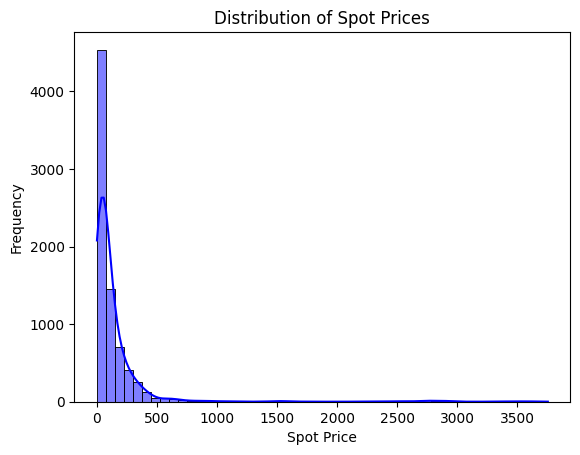

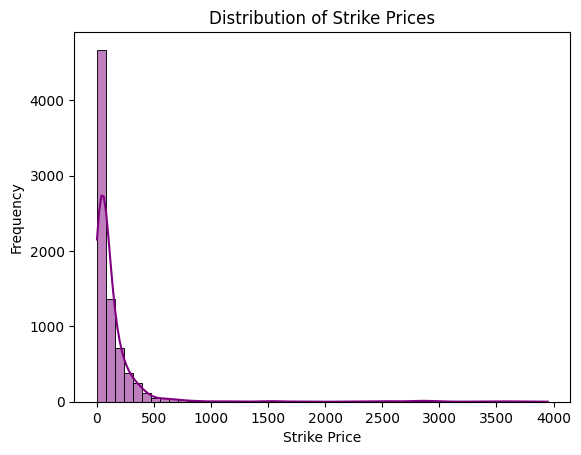

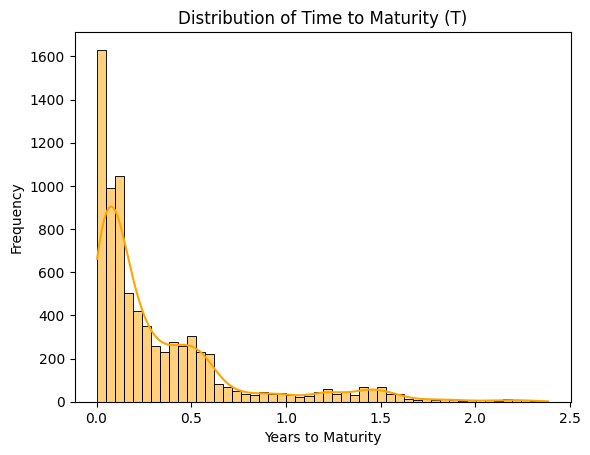

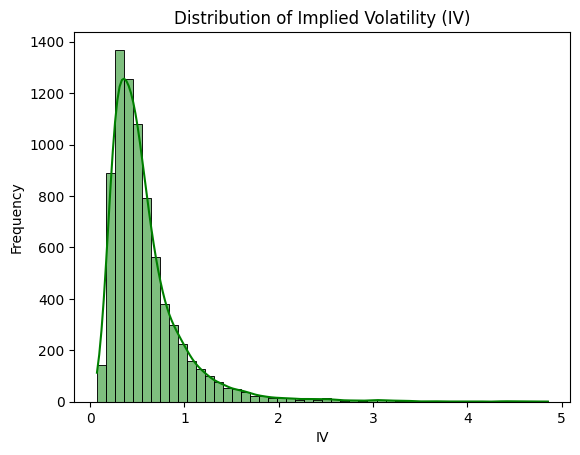

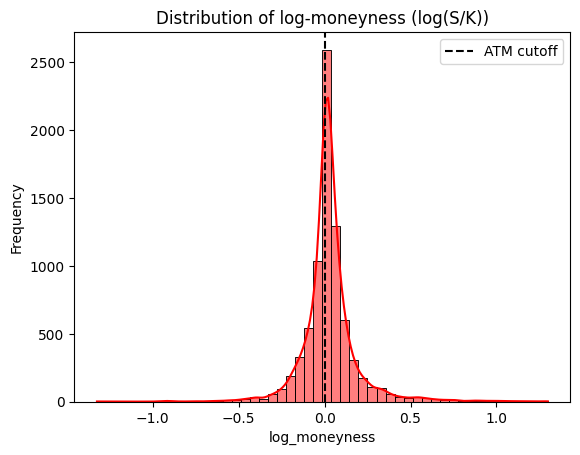

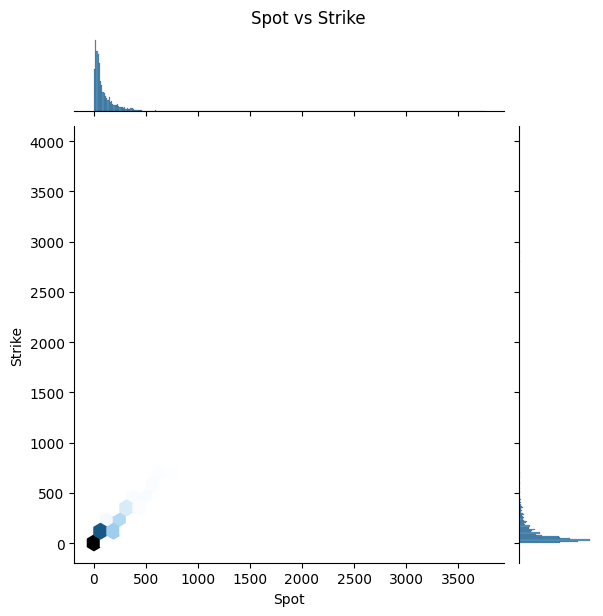

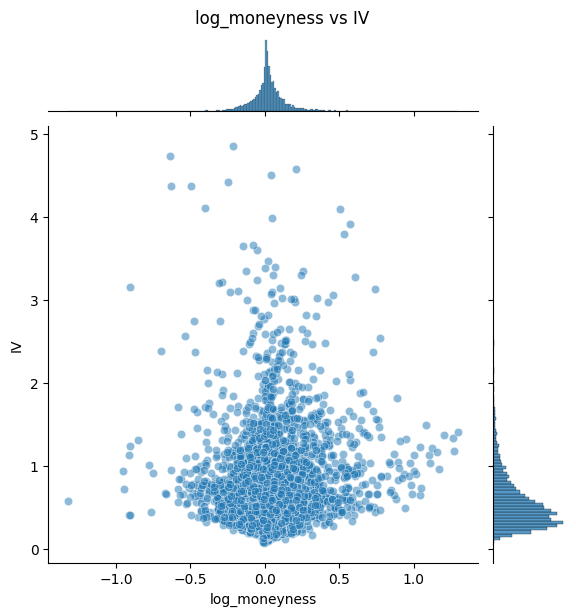

In [24]:
import seaborn as sns
sns.histplot(df_with_iv['Spot'], bins=50, kde=True, color='blue')
plt.title("Distribution of Spot Prices")
plt.xlabel("Spot Price")
plt.ylabel("Frequency")
plt.show()

sns.histplot(df_with_iv['Strike'], bins=50, kde=True, color='purple')
plt.title("Distribution of Strike Prices")
plt.xlabel("Strike Price")
plt.ylabel("Frequency")
plt.show()

sns.histplot(df_with_iv['T'], bins=50, kde=True, color='orange')
plt.title("Distribution of Time to Maturity (T)")
plt.xlabel("Years to Maturity")
plt.ylabel("Frequency")
plt.show()

sns.histplot(df_with_iv['IV'], bins=50, kde=True, color='green')
plt.title("Distribution of Implied Volatility (IV)")
plt.xlabel("IV")
plt.ylabel("Frequency")
plt.show()

sns.histplot(df_with_iv['log_moneyness'], bins=50, kde=True, color='red')
plt.title("Distribution of log-moneyness (log(S/K))")
plt.xlabel("log_moneyness")
plt.ylabel("Frequency")
plt.axvline(0, color='black', linestyle='--', label="ATM cutoff")
plt.legend()
plt.show()

sns.jointplot(x='Spot', y='Strike', data=df_with_iv, kind='hex', gridsize=30)
plt.suptitle("Spot vs Strike", y=1.02)
plt.show()

sns.jointplot(x='log_moneyness', y='IV', data=df_with_iv, kind='scatter', alpha=0.5)
plt.suptitle("log_moneyness vs IV", y=1.02)
plt.show()

Newly cmoputed columns:
| Column         | Description                                                                 |
|----------------|-----------------------------------------------------------------------------|
| `T`            | Time to maturity (in years). Computed as days to expiration divided by 365 |
| `IV`           | Implied Volatility — estimated using the Black-Scholes model               |
| `moneyness`    | Ratio of Strike to Spot: `Strike / Spot`. Values near 1 are ATM            |
| `log_moneyness`| Natural log of moneyness: `log(Strike / Spot)`. Zero at ATM                |
| `atm_weight`   | Gaussian weight centered at ATM: `exp(-log_moneyness² / (2 * σ²))`         |

## Understanding the fitting problem

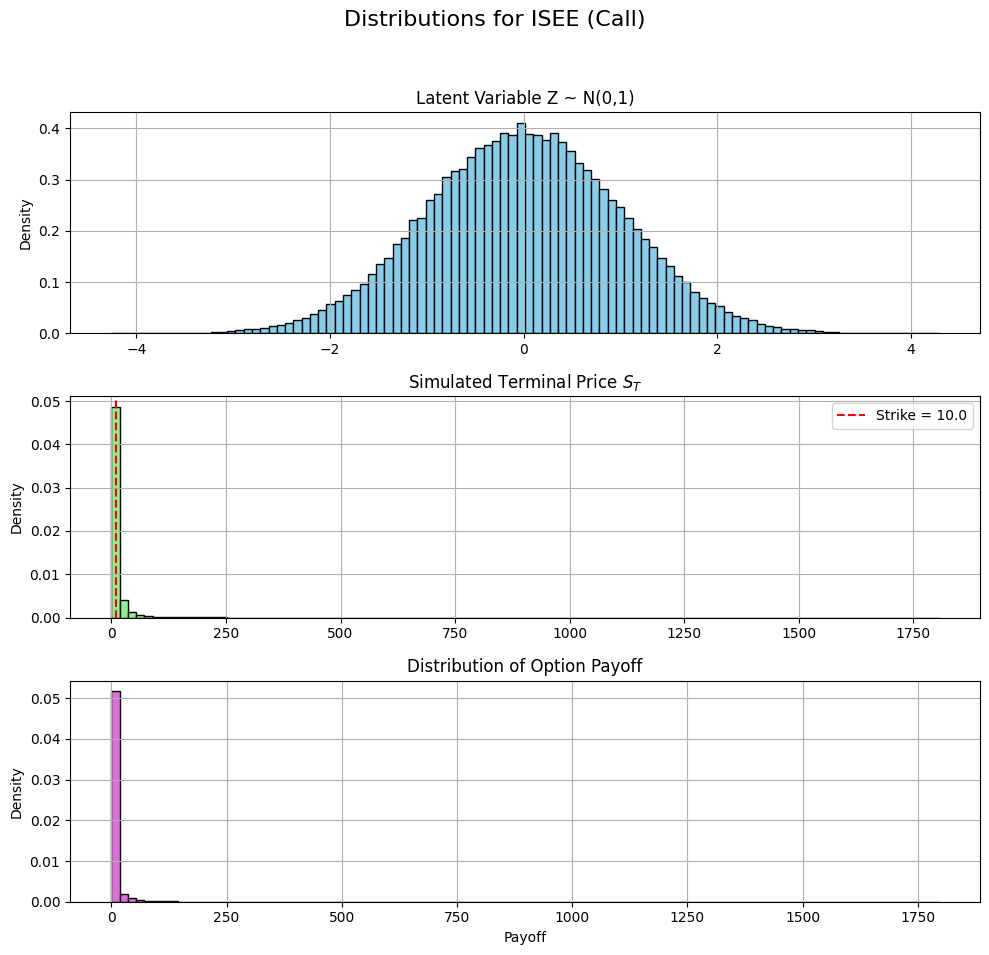

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_option_distributions(row, r=0.01, N=100000):
    # Extract inputs
    S0 = float(row['Spot'])
    K = float(row['Strike'])
    T = float(row['T'])     # Assumed to be in years already
    sigma = float(row['IV'])  # IV should be available in the row
    option_type = row['C/P'].strip().lower()

    # Sample Z ~ N(0, 1)
    Z = np.random.normal(0, 1, N)

    # Simulate S_T under Black-Scholes
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    # Compute payoff
    if option_type == 'call':
        payoff = np.maximum(ST - K, 0)
    else:
        payoff = np.maximum(K - ST, 0)

    # --- PLOTS ---
    fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=False)
    fig.suptitle(f"Distributions for {row['Sym']} ({row['C/P'].title()})", fontsize=16)

    # Plot distribution of Z
    axs[0].hist(Z, bins=100, density=True, color="skyblue", edgecolor='black')
    axs[0].set_title("Latent Variable Z ~ N(0,1)")
    axs[0].set_ylabel("Density")
    axs[0].grid(True)

    # Plot distribution of S_T
    axs[1].hist(ST, bins=100, density=True, color="lightgreen", edgecolor='black')
    axs[1].axvline(K, color='red', linestyle='--', label=f'Strike = {K}')
    axs[1].set_title(r"Simulated Terminal Price $S_T$")
    axs[1].set_ylabel("Density")
    axs[1].legend()
    axs[1].grid(True)

    # Plot distribution of payoff
    axs[2].hist(payoff, bins=100, density=True, color="orchid", edgecolor='black')
    axs[2].set_title("Distribution of Option Payoff")
    axs[2].set_xlabel("Payoff")
    axs[2].set_ylabel("Density")
    axs[2].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_option_distributions(df_with_iv.iloc[0], r=0.01, N=100000)

#### 1. Latent Variable — Standard Normal Distribution

We begin by sampling from the standard normal distribution:

$$
Z \sim \mathcal{N}(0, 1)
$$

This variable represents the **log-return shock** under the risk-neutral measure in the Black-Scholes model.

---

#### 2. Simulating Terminal Asset Price $S_T$ (Black-Scholes Model)

Under the Black-Scholes risk-neutral framework, the terminal price of the underlying asset at expiry is given by:

$$
S_T = S_0 \cdot \exp\left( \left( r - \frac{1}{2} \sigma^2 \right) T + \sigma \sqrt{T} \cdot Z \right)
$$

Where:
- $S_0$ = current spot price
- $r$ = risk-free rate
- $\sigma$ = volatility (implied or estimated)
- $T$ = time to maturity (in years)
- $Z \sim \mathcal{N}(0, 1)$

This produces a **log-normal distribution** for $S_T$.

---

#### 3. Option Payoff Function

##### Call Option Payoff:

$$
\text{Payoff}_{\text{call}}(S_T) = \max(S_T - K, \, 0)
$$

##### Put Option Payoff:

$$
\text{Payoff}_{\text{put}}(S_T) = \max(K - S_T, \, 0)
$$

Where:
- $K$ = strike price
- $S_T$ = simulated terminal price
- The `max` function ensures that the payoff is non-negative

---

#### 4. Expected Payoff (Option Value Estimate)

In the risk-neutral framework, the fair value of the option at time 0 is:

$$
V_0 = e^{-rT} \cdot \mathbb{E}_{\mathbb{Q}}\left[ \text{Payoff}(S_T) \right]
$$

Where:
- $\mathbb{E}_{\mathbb{Q}}$ is the expectation under the risk-neutral measure
- No closed-form in simulation: this is estimated via Monte Carlo.

For Monte Carlo simulation:
$$
V_0 \approx \frac{e^{-rT}}{N} \sum_{i=1}^{N} \text{Payoff}(S_T^{(i)})
$$

---

### Summary

- $Z$ is standard normal
- $S_T$ is log-normal (via transformation of $Z$)
- Payoff is a piecewise function, shaped by $K$ and $S_T$
- The value is the expectation over the payoff region

written as a function of $Z \sim \mathcal{N}(0, 1)$

In [7]:
# Filter out extreme values for easier fitting
df_iv_filtered = df_with_iv[(df_with_iv['IV'] > 0) & (df_with_iv['IV'] < 2.0)]

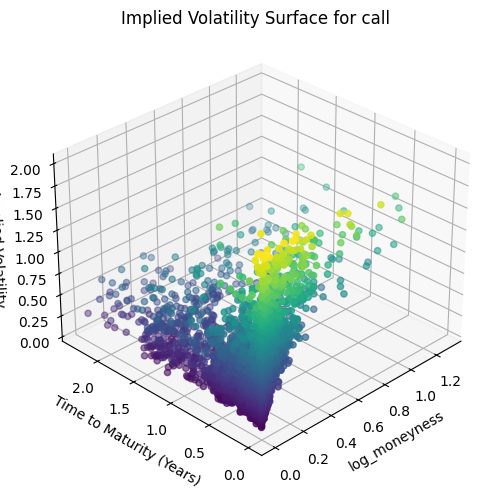

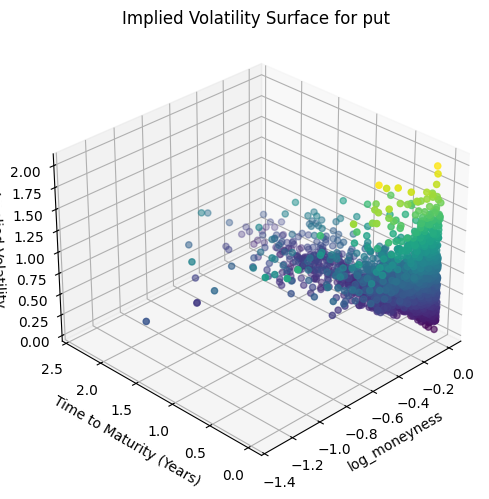

In [8]:
# Visualize the surface to be fitted
from adaptiveIS import plot_iv_surface
plot_iv_surface(df_iv_filtered, option_type='call', strike_col='log_moneyness')
plot_iv_surface(df_iv_filtered, option_type='put', strike_col='log_moneyness')

Here we see the signature smiley shape and center at around 0 for log_moneyness.

# Options pricing

## Implementation of AIS and regular IS

In [ ]:
# Change this before each runthrough
num_samples=20000
starting_mu = -3

### AIS

In [478]:
import numpy as np
from scipy.stats import norm

def adaptive_importance_sampling_df(row, r=0.01, 
        N=num_samples, tol=1e-4, max_iter=50, verbose=False):
    # Extract values from DataFrame row
    S0 = float(row['Spot'])        # Spot price
    K = float(row['Strike'])       # Strike
    T = float(row['T'])            # Time to maturity
    sigma = float(row['IV'])       # Implied volatility
    option_type = row['C/P'].lower()

    # Market benchmark: use MidPrice or BidAsk as placeholder
    market_price = float(row['BidAsk'])

    # Handle string formats like '310.6K'
    if isinstance(market_price, str):
        market_price = market_price.upper().replace(',', '').strip()
        if 'K' in market_price:
            market_price = float(market_price.replace('K', '')) * 1e3
        elif 'M' in market_price:
            market_price = float(market_price.replace('M', '')) * 1e6
        else:
            market_price = float(market_price)

    # INIT: proposal parameters
    mu = starting_mu
    sigma_prop = 1.0
    prev_price = 0.0
    prices = []
    trace = []

    for it in range(max_iter):
        Z = np.random.normal(loc=mu, scale=sigma_prop, size=N)
        # Simulate terminal price and payoff
        ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
        if option_type == 'call':
            payoff = np.maximum(ST - K, 0)
        else:
            payoff = np.maximum(K - ST, 0)

        # Importance weights w = p(z) / q(z)
        p_z = norm.pdf(Z, loc=0, scale=1)
        q_z = norm.pdf(Z, loc=mu, scale=sigma_prop)
        weights = p_z / q_z
        discounted = np.exp(-r * T) * payoff * weights
        price = np.mean(discounted)
        prices.append(price)

        # Track trace info for this iteration
        trace.append({
            'iter': it,
            'mu': mu,
            'sigma_prop': sigma_prop,
            'Z':Z,
            'price_est': price,
            'payoff': payoff,
            'weights': weights,
            'mean_weight': np.mean(weights),
            'std_weight': np.std(weights),
            'effective_samples': (np.sum(weights) ** 2) / np.sum(weights**2),  # ESS metric
        })

        # Check convergence
        if abs(price - prev_price)/(prev_price+1e-6) < tol and it > 1:
            if verbose:
                print(f"[{row['Sym']} {option_type}] Converged at iter {it+1}")
            break
        prev_price = price

        # Normalize weights
        weights += 1e-12  # to prevent divide-by-zero
        weights /= np.sum(weights)

        # Weighted update of mu and sigma
        mu = np.sum(weights * Z)
        var = np.sum(weights * (Z - mu)**2)
        sigma_prop = np.sqrt(var)

        if verbose:
            print(f"Iter {it+1:02d}: price={price:.4f}, mu={mu:.4f}, sigma={sigma_prop:.4f}")

    # Return result with trace
    return {
        'symbol': row['Sym'], 
        'strike': K,
        'spot': S0,
        'option_type': option_type,
        'AIS_price': price,
        'Market_price': market_price,
        'Price_error': price - market_price,
        'final_mu': mu,
        'final_sigma_prop': sigma_prop,
        'iters': it + 1,
        'trace': trace
    }

### Regular IS

In [481]:
def vanilla_importance_sampling_df(row, r=0.01, N=num_samples, 
                                    mu_fixed=starting_mu, sigma_fixed=1.0,
                                    tol=1e-4, max_iter=50, verbose=False):
    # Extract info from row
    S0 = float(row['Spot'])
    K = float(row['Strike'])
    T = float(row['T'])
    sigma = float(row['IV'])
    option_type = row['C/P'].lower()

    # Use BidAsk or MidPrice as market benchmark
    market_price = float(row['BidAsk'])
    if isinstance(market_price, str):
        market_price = market_price.upper().replace(',', '').strip()
        if 'K' in market_price:
            market_price = float(market_price.replace('K', '')) * 1e3
        elif 'M' in market_price:
            market_price = float(market_price.replace('M', '')) * 1e6
        else:
            market_price = float(market_price)

    prev_price = 0.0
    trace = []

    for it in range(max_iter):
        # Sample from fixed proposal: q(z) ~ N(mu_fixed, sigma_fixed)
        Z = np.random.normal(loc=mu_fixed, scale=sigma_fixed, size=N)

        # Simulate terminal price
        ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

        # Payoff
        if option_type == 'call':
            payoff = np.maximum(ST - K, 0)
        else:
            payoff = np.maximum(K - ST, 0)

        # Importance weights w = p(z) / q(z)
        p_z = norm.pdf(Z, loc=0, scale=1)
        q_z = norm.pdf(Z, loc=mu_fixed, scale=sigma_fixed)
        weights = p_z / q_z

        discounted_payoff = np.exp(-r * T) * payoff * weights
        price = np.mean(discounted_payoff)

        # Track iteration diagnostics
        trace.append({
            'iter': it,
            'mu': mu_fixed,
            'sigma_prop': sigma_fixed,
            'Z':Z,
            'price_est': price,
            'payoff': payoff,
            'weights': weights,
            'mean_weight': np.mean(weights),
            'std_weight': np.std(weights),
            'effective_samples': (np.sum(weights) ** 2) / np.sum(weights**2),  # ESS metric
        })

        if verbose:
            print(f"[{row['Sym']} {option_type}] Iter {it+1}: Price={price:.5f}")

        # Check for convergence
        if abs(price - prev_price)/(prev_price+1e-6) < tol and it > 1:
            if verbose:
                print(f"Converged at iteration {it+1} with price={price:.5f}")
            break

        prev_price = price

    return {
        'symbol': row['Sym'], 
        'strike': K,
        'spot': S0,
        'option_type': option_type,
        'IS_price': price,
        'Market_price': market_price,
        'Price_error': price - market_price,
        'final_mu': mu_fixed,
        'final_sigma_prop': sigma_fixed,
        'iters': it + 1,
        'trace': trace
    }

## Grepping the most out-of-the-market (low probability) samples for AIS

In [482]:
df_calls = df_iv_filtered[df_iv_filtered['C/P'].str.lower() == 'call']
df_calls_bad = df_calls.sort_values('log_moneyness', ascending=False) # usually false
df_puts  = df_iv_filtered[df_iv_filtered['C/P'].str.lower() == 'put']
df_puts_bad = df_puts.sort_values('log_moneyness', ascending=True) # usually true

In [483]:
df_calls_bad

,Time,Sym,C/P,Exp,Strike,Spot,BidAsk,Orders,Vol,Prems,...,Diff(%),ITM,MidPrice,Date,ExpirationDate,T,IV,moneyness,log_moneyness,atm_weight
7257,6/29/2021 10:51,SOS,call,1/21/2022,12.5,3.41,0.33,6,13.12K,445.91K,...,267.29,0,0.33,2021-06-29,2022-01-21,0.564384,1.401173,3.665689,1.299016,1.066409e-14
4874,8/27/2021 9:33,AMC,call,1/20/2023,145.0,40.78,9.28,5,618,623.74K,...,260.25,0,9.28,2021-08-27,2023-01-20,1.400000,1.180963,3.555665,1.268542,4.740153e-14
1914,12/30/2021 14:16,MARA,call,6/17/2022,125.0,35.32,2.12,5,980,217.14K,...,255.43,0,2.12,2021-12-30,2022-06-17,0.463014,1.335523,3.539071,1.263864,5.941203e-14
7785,6/8/2021 10:50,SENS,call,1/20/2023,10.0,3.01,1.15,8,5.51K,661.77K,...,234.87,0,1.15,2021-06-08,2023-01-20,1.619178,1.376883,3.322259,1.200645,1.158620e-12
6826,7/12/2021 11:32,MARA,call,1/20/2023,85.0,26.47,4.38,5,590,265.50K,...,221.19,0,4.38,2021-07-12,2023-01-20,1.526027,0.958015,3.211182,1.166639,5.376434e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7085,7/2/2021 12:11,PENN,call,1/21/2022,75.0,75.00,12.28,5,343,423.31K,...,0.05,1,12.28,2021-07-02,2022-01-21,0.556164,0.546220,1.000000,0.000000,1.000000e+00
5455,8/12/2021 13:21,T,call,1/21/2022,28.0,28.00,1.15,5,2.79K,323.12K,...,0.02,1,1.15,2021-08-12,2022-01-21,0.443836,0.146432,1.000000,0.000000,1.000000e+00
5573,8/10/2021 11:24,RBLX,call,8/20/2021,85.0,85.00,5.30,5,310,161.55K,...,0.33,1,5.30,2021-08-10,2021-08-20,0.027397,0.943274,1.000000,0.000000,1.000000e+00
3910,10/5/2021 15:12,PERI,call,4/14/2022,20.0,20.00,3.75,5,500,187.70K,...,0.06,1,3.75,2021-10-05,2022-04-14,0.523288,0.648196,1.000000,0.000000,1.000000e+00


In [484]:
AIS_calls = df_calls_bad.head(50).apply(lambda row: adaptive_importance_sampling_df(row), axis=1)
AIS_puts = df_puts_bad.head(50).apply(lambda row: adaptive_importance_sampling_df(row), axis=1)
IS_calls = df_calls_bad.head(50).apply(lambda row: vanilla_importance_sampling_df(row), axis=1)
IS_puts = df_puts_bad.head(50).apply(lambda row: vanilla_importance_sampling_df(row), axis=1)

## Evaluation and Plotting
### Results summary

In [485]:
# Turn into DataFrames
AIS_calls_df = pd.DataFrame(list(AIS_calls))
AIS_puts_df = pd.DataFrame(list(AIS_puts))
IS_calls_df = pd.DataFrame(list(IS_calls))
IS_puts_df = pd.DataFrame(list(IS_puts))

def evaluate_AIS_pricing(df, label=''):
    df['abs_error'] = np.abs(df['AIS_price'] - df['Market_price'])
    df['rel_error'] = df['abs_error'] / (df['Market_price'] + 1e-6)
    
    return {
        'Label': label,
        'Mean_AIS': df['AIS_price'].mean(),
        'Mean_Market': df['Market_price'].mean(),
        'MAE': df['abs_error'].mean(),
        'MAPE': df['rel_error'].mean(),
        'RMSE': np.sqrt(np.mean((df['AIS_price'] - df['Market_price'])**2)),
        'N': len(df)
    }

def evaluate_IS_pricing(df, label=''):
    df['abs_error'] = np.abs(df['IS_price'] - df['Market_price'])
    df['rel_error'] = df['abs_error'] / (df['Market_price'] + 1e-6)
    
    return {
        'Label': label,
        'Mean_AIS': df['IS_price'].mean(),
        'Mean_Market': df['Market_price'].mean(),
        'MAE': df['abs_error'].mean(),
        'MAPE': df['rel_error'].mean(),
        'RMSE': np.sqrt(np.mean((df['IS_price'] - df['Market_price'])**2)),
        'N': len(df)
    }

results_summary = pd.DataFrame([
    evaluate_AIS_pricing(AIS_calls_df, 'AIS_calls'),
    evaluate_AIS_pricing(AIS_puts_df, 'AIS_puts'),
    evaluate_IS_pricing(IS_calls_df, 'IS_calls'),
    evaluate_IS_pricing(IS_puts_df, 'IS_puts')
])

print(results_summary)

       Label  Mean_AIS  Mean_Market       MAE      MAPE      RMSE   N
0  AIS_calls  3.264931       3.2220  0.127983  0.039358  0.224172  50
1   AIS_puts  3.142362       3.1416  0.020245  0.009258  0.029874  50
2   IS_calls  0.000000       3.2220  3.222000  0.999999  4.517599  50
3    IS_puts  3.152090       3.1416  0.055940  0.013780  0.117890  50


### Comparing real values with AIS predicted values

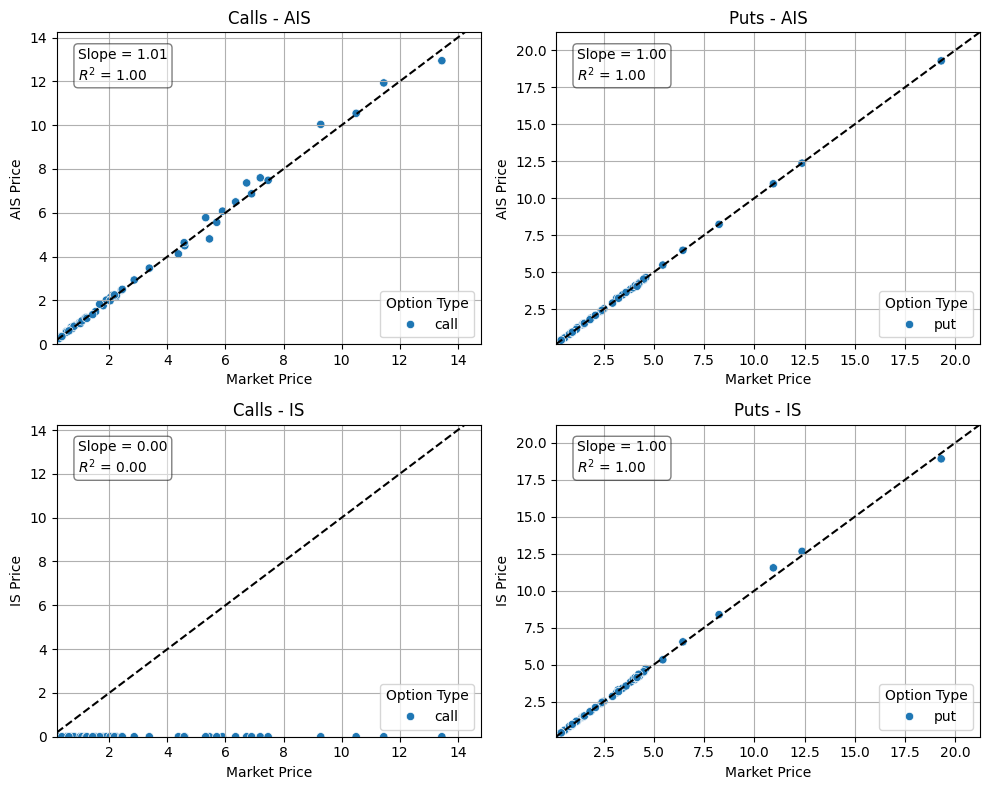

In [486]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

def plot_comparative_subplots(AIS_calls_df, AIS_puts_df, IS_calls_df, IS_puts_df):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=False, sharey=False)
    plt.subplots_adjust(hspace=0.3, wspace=0.25)
    # ----- Compute shared axis limits -----

    # For calls
    call_xmin = (min(AIS_calls_df['Market_price'].min(), IS_calls_df['Market_price'].min()))*0.9
    call_xmax = (max(AIS_calls_df['Market_price'].max(), IS_calls_df['Market_price'].max()))*1.1
    call_ymin = (min(AIS_calls_df['AIS_price'].min(), IS_calls_df['IS_price'].min()))*0.9
    call_ymax = (max(AIS_calls_df['AIS_price'].max(), IS_calls_df['IS_price'].max()))*1.1

    # For puts
    put_xmin = (min(AIS_puts_df['Market_price'].min(), IS_puts_df['Market_price'].min()))*0.9
    put_xmax = (max(AIS_puts_df['Market_price'].max(), IS_puts_df['Market_price'].max()))*1.1
    put_ymin = (min(AIS_puts_df['AIS_price'].min(), IS_puts_df['IS_price'].min()))*0.9
    put_ymax = (max(AIS_puts_df['AIS_price'].max(), IS_puts_df['IS_price'].max()))*1.1

    # ----- Top Left: AIS Calls -----
    # ----- Compute shared axis limits -----
    # For calls
    call_xmin = min(AIS_calls_df['Market_price'].min(), IS_calls_df['Market_price'].min()) * 0.9
    call_xmax = max(AIS_calls_df['Market_price'].max(), IS_calls_df['Market_price'].max()) * 1.1
    call_ymin = min(AIS_calls_df['AIS_price'].min(), IS_calls_df['IS_price'].min()) * 0.9
    call_ymax = max(AIS_calls_df['AIS_price'].max(), IS_calls_df['IS_price'].max()) * 1.1

    # For puts
    put_xmin = min(AIS_puts_df['Market_price'].min(), IS_puts_df['Market_price'].min()) * 0.9
    put_xmax = max(AIS_puts_df['Market_price'].max(), IS_puts_df['Market_price'].max()) * 1.1
    put_ymin = min(AIS_puts_df['AIS_price'].min(), IS_puts_df['IS_price'].min()) * 0.9
    put_ymax = max(AIS_puts_df['AIS_price'].max(), IS_puts_df['IS_price'].max()) * 1.1

    # Helper function for regression annotation
    def annotate_regression(ax, x, y):
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        r_squared = r_value ** 2
        ax.text(0.05, 0.95, f"Slope = {slope:.2f}\n$R^2$ = {r_squared:.2f}",
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# ----- Top Left: AIS Calls -----
    ax = axes[0, 0]
    sns.scatterplot(data=AIS_calls_df, x='Market_price', y='AIS_price', hue='option_type', ax=ax)
    ax.plot([call_xmin, call_xmax], [call_xmin, call_xmax], 'k--')
    annotate_regression(ax, AIS_calls_df['Market_price'], AIS_calls_df['AIS_price'])
    ax.set_title("Calls - AIS")
    ax.set_xlabel("Market Price")
    ax.set_ylabel("AIS Price")
    ax.set_xlim(call_xmin, call_xmax)
    ax.set_ylim(call_ymin, call_ymax)
    ax.grid(True)

    # ----- Top Right: AIS Puts -----
    ax = axes[0, 1]
    sns.scatterplot(data=AIS_puts_df, x='Market_price', y='AIS_price', hue='option_type', ax=ax)
    ax.plot([put_xmin, put_xmax], [put_xmin, put_xmax], 'k--')
    annotate_regression(ax, AIS_puts_df['Market_price'], AIS_puts_df['AIS_price'])
    ax.set_title("Puts - AIS")
    ax.set_xlabel("Market Price")
    ax.set_ylabel("AIS Price")
    ax.set_xlim(put_xmin, put_xmax)
    ax.set_ylim(put_ymin, put_ymax)
    ax.grid(True)

    # ----- Bottom Left: IS Calls -----
    ax = axes[1, 0]
    sns.scatterplot(data=IS_calls_df, x='Market_price', y='IS_price', hue='option_type', ax=ax)
    ax.plot([call_xmin, call_xmax], [call_xmin, call_xmax], 'k--')
    annotate_regression(ax, IS_calls_df['Market_price'], IS_calls_df['IS_price'])
    ax.set_title("Calls - IS")
    ax.set_xlabel("Market Price")
    ax.set_ylabel("IS Price")
    ax.set_xlim(call_xmin, call_xmax)
    ax.set_ylim(call_ymin, call_ymax)
    ax.grid(True)

    # ----- Bottom Right: IS Puts -----
    ax = axes[1, 1]
    sns.scatterplot(data=IS_puts_df, x='Market_price', y='IS_price', hue='option_type', ax=ax)
    ax.plot([put_xmin, put_xmax], [put_xmin, put_xmax], 'k--')
    annotate_regression(ax, IS_puts_df['Market_price'], IS_puts_df['IS_price'])
    ax.set_title("Puts - IS")
    ax.set_xlabel("Market Price")
    ax.set_ylabel("IS Price")
    ax.set_xlim(put_xmin, put_xmax)
    ax.set_ylim(put_ymin, put_ymax)
    ax.grid(True)

    for ax in axes.flat:
        ax.legend().set_title("Option Type")

    plt.tight_layout()
    # plt.suptitle(f"AIS and IS pricing at N={num_samples} and mu={starting_mu}", fontsize=16)
    plt.show()

plot_comparative_subplots(AIS_calls_df, AIS_puts_df, IS_calls_df, IS_puts_df)


Both slope and R^2 should approach 1.

### Quantifying relative errors

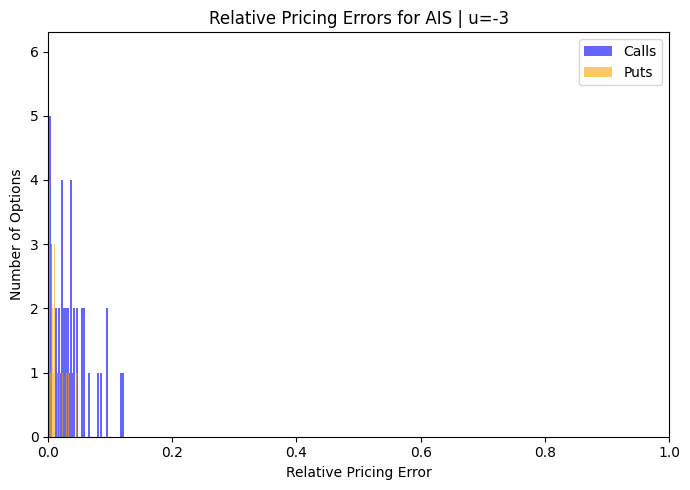

In [487]:
def plot_rel_error_histograms(calls_df, puts_df, bins=20):
    # Compute relative error if not already present
    calls_df['rel_error'] = abs(calls_df['AIS_price'] - calls_df['Market_price']) / (calls_df['Market_price'] + 1e-6)
    puts_df['rel_error'] = abs(puts_df['AIS_price'] - puts_df['Market_price']) / (puts_df['Market_price'] + 1e-6)

    plt.figure(figsize=(7, 5))
    plt.xlim(0,1)
    # plt.ylim(0,15)
    # Overlay histograms
    plt.hist(calls_df['rel_error'], bins=bins, color='blue', alpha=0.6, label='Calls')
    plt.hist(puts_df['rel_error'], bins=bins, color='orange', alpha=0.6, label='Puts')

    # Labels and formatting
    plt.xlabel('Relative Pricing Error')
    plt.ylabel('Number of Options')
    plt.title(f'Relative Pricing Errors for AIS | u={starting_mu}')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_rel_error_histograms(AIS_calls_df, AIS_puts_df, bins=50)

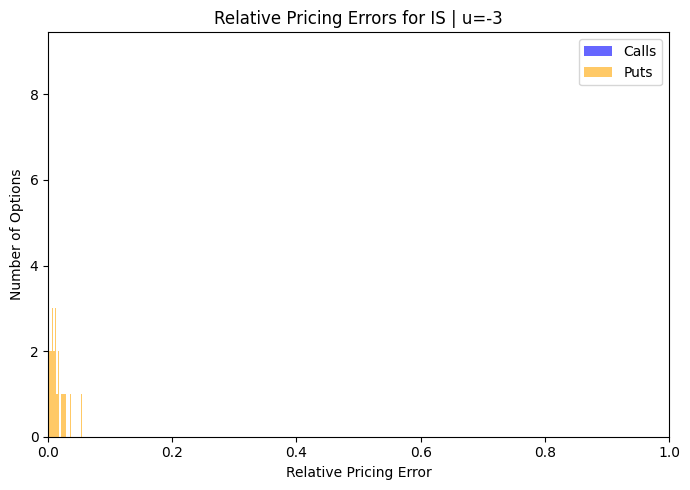

In [488]:
def plot_rel_error_histograms(calls_df, puts_df, bins=20):
    # Compute relative error if not already present
    calls_df['rel_error'] = abs(calls_df['IS_price'] - calls_df['Market_price']) / (calls_df['Market_price'] + 1e-6)
    puts_df['rel_error'] = abs(puts_df['IS_price'] - puts_df['Market_price']) / (puts_df['Market_price'] + 1e-6)

    plt.figure(figsize=(7, 5))
    plt.xlim(0,1)
    # plt.ylim(0,15)
    # Overlay histograms
    plt.hist(calls_df['rel_error'], bins=bins, color='blue', alpha=0.6, label='Calls')
    plt.hist(puts_df['rel_error'], bins=bins, color='orange', alpha=0.6, label='Puts')

    # Labels and formatting
    plt.xlabel('Relative Pricing Error')
    plt.ylabel('Number of Options')
    plt.title(f'Relative Pricing Errors for IS | u={starting_mu}')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_rel_error_histograms(IS_calls_df, IS_puts_df, bins=50)

In [491]:
def plot_diagnostics(result, title):
    trace = result['trace']
    market_price = result['Market_price']
    symbol = result['symbol']
    iters = [d['iter'] for d in trace]
    price_est = [d['price_est'] for d in trace]
    mus = [d['mu'] for d in trace]
    sigmas = [d['sigma_prop'] for d in trace]
    mean_weights = [d['mean_weight'] for d in trace]
    std_weights = [d['std_weight'] for d in trace]
    ess = [d['effective_samples'] for d in trace]

    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f"{title} - {symbol}", fontsize=16)

    # --- Plot 1: AIS vs Market Price ---
    axs[0].plot(iters, price_est, marker='o', linestyle='-', color='blue', label='AIS Estimated Price')
    axs[0].axhline(market_price, color='gray', linestyle='--', label='Market Price')
    axs[0].set_ylabel("Option Price")
    axs[0].set_title("1. Price Convergence vs Market")
    axs[0].legend()
    axs[0].grid(True)
    axs[0].set_ylim([0,11])

    # --- Plot 2: Proposal Distribution (Mu, Sigma) ---
    axs[1].plot(iters, mus, marker='o', label='Mu (Center)', color='green')
    axs[1].plot(iters, sigmas, marker='x', label='Sigma (Spread)', color='orange')
    axs[1].set_ylabel("Parameter Value")
    axs[1].set_title("2. Proposal Distribution Evolution (Mu, Sigma)")
    axs[1].legend()
    axs[1].grid(True)

    # --- Plot 3: Weight Metrics ---
    axs[2].plot(iters, mean_weights, label="Mean Weight", color='purple')
    axs[2].plot(iters, std_weights, label="Weight Std Dev", color='red')
    axs[2].plot(iters, ess, label="Effective Sample Size (ESS)", color='brown')
    axs[2].set_xlabel("Iteration")
    axs[2].set_ylabel("Weight Metrics")
    axs[2].set_title("3. Importance Sampling Weights")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Plotting convergence
Here we pick 1 example from call and put for both AIS and IS and plot their estimated price against market price below, as well as sampling parameters $\mu$ and $\sigma$. AIS will adjust the proposal distribution to follow $\mathcal{N} \sim (\mu, \sigma)$ whereas they are fixed to the initialization for regular IS.

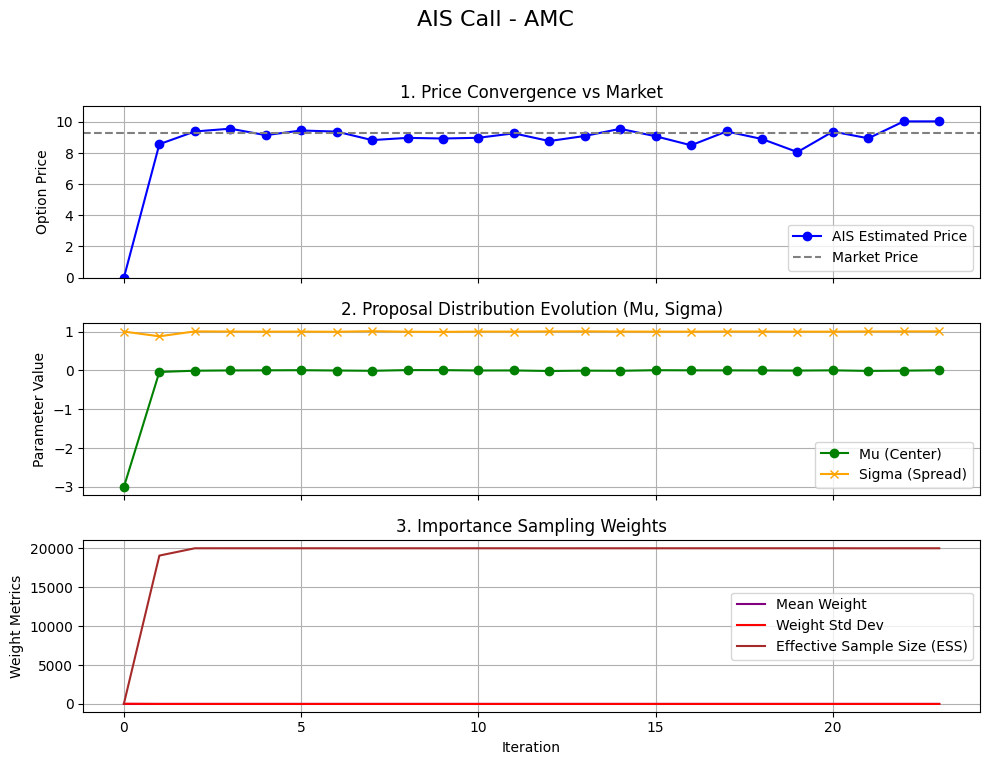

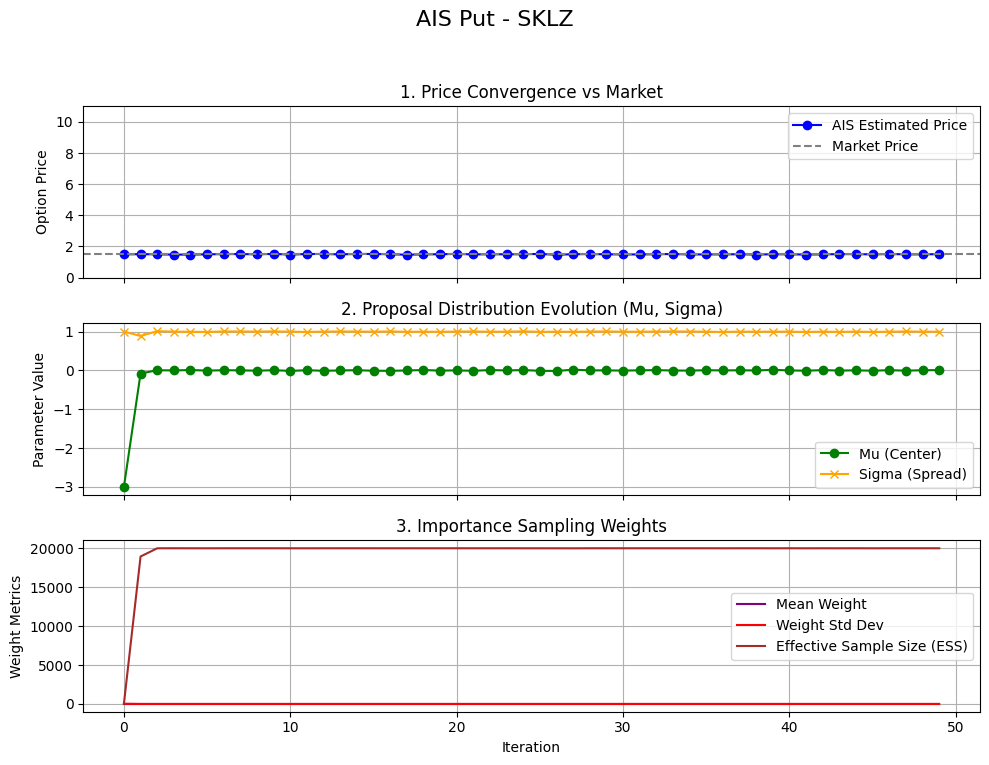

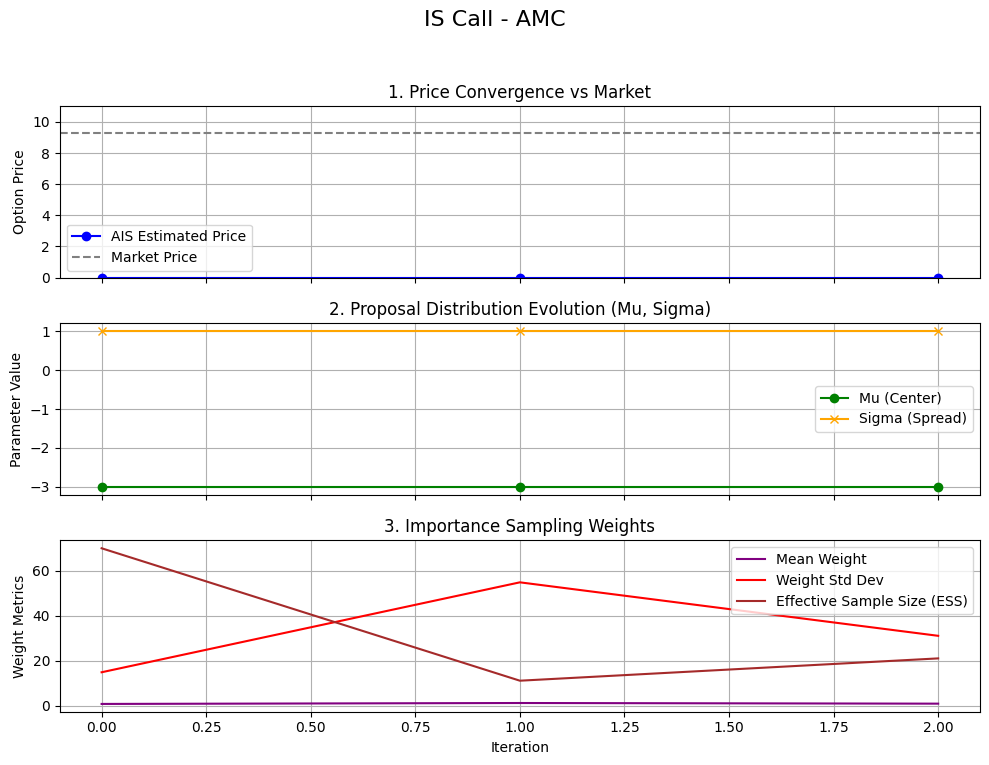

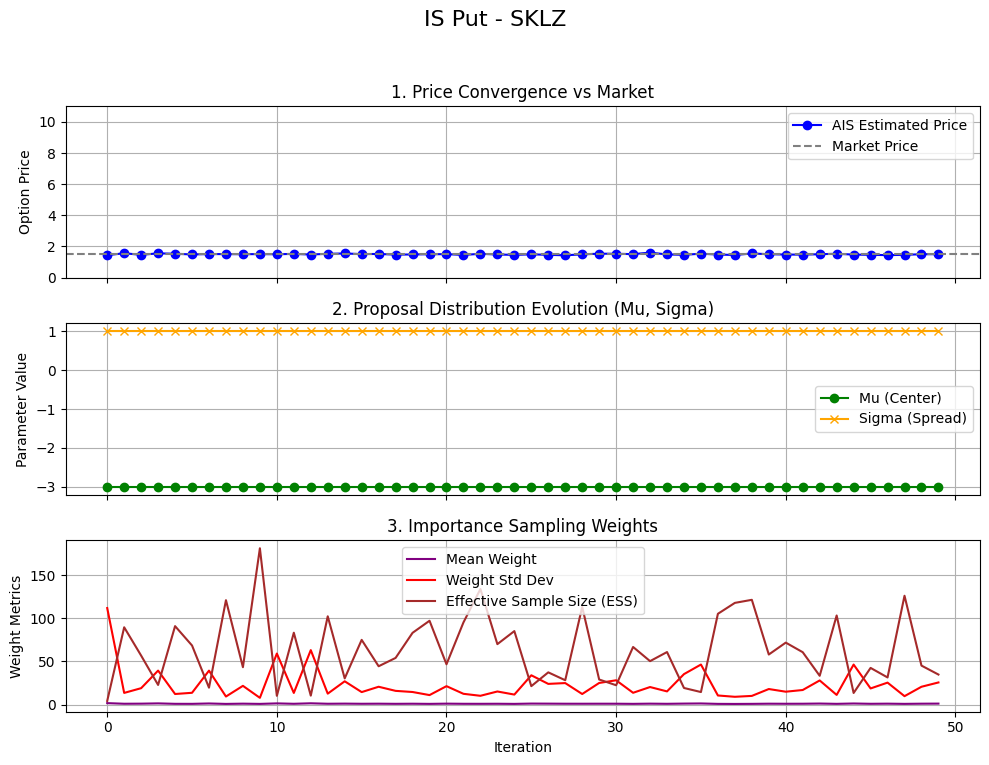

In [492]:
plot_diagnostics(AIS_calls_df.iloc[1], title="AIS Call")
plot_diagnostics(AIS_puts_df.iloc[1], title="AIS Put")
plot_diagnostics(IS_calls_df.iloc[1], title="IS Call")
plot_diagnostics(IS_puts_df.iloc[1], title="IS Put")

### Save proposal distribution converging to traget distribution as a gif

In [497]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import norm
import os
from PIL import Image

def visualize_evolution_from_trace(trace, n_iters=10, symbol='Option', output_gif='ais_evolution.gif'):
    frames = []
    # Create a directory for temporary frames
    os.makedirs("temp_frames", exist_ok=True)

    # Step 1: Determine fixed y-axis limits
    Z_sorted = np.linspace(-5, 5, 1000)
    max_pz = norm.pdf(0, 0, 1)  # Maximum of standard normal
    max_qz = 0
    max_hist = 0
    max_payoff = float('-inf')
    min_payoff = float('inf')

    for step in trace[:n_iters]:
        Z = step['Z']
        payoffs = step['payoff']
        mu = step['mu']
        sigma = step['sigma_prop']

        q_z = norm.pdf(Z_sorted, mu, sigma)
        max_qz = max(max_qz, np.max(q_z))
        hist_values, _ = np.histogram(Z, bins=40, density=True)
        max_hist = max(max_hist, np.max(hist_values))

        max_payoff = max(max_payoff, np.max(payoffs))
        min_payoff = min(min_payoff, np.min(payoffs))

    y_max_top = max(max_pz, max_qz, max_hist) * 1.1  # Add margin
    y_min_bottom = min_payoff - 0.1 * abs(min_payoff)
    y_max_bottom = max_payoff + 0.1 * abs(max_payoff)

    # Step 2: Generate individual plots
    for i in range(n_iters):
        step = trace[i]
        Z = step['Z']
        weights = step['weights']
        payoffs = step['payoff']
        mu = step['mu']
        sigma = step['sigma_prop']
        price = step['price_est']

        N = len(Z)

        p_z = norm.pdf(Z_sorted, 0, 1)
        q_z = norm.pdf(Z_sorted, mu, sigma)

        fig, axs = plt.subplots(2, 1, figsize=(10, 8))
        fig.suptitle(f"AIS Evolution — {symbol} | Iteration {i+1}/{n_iters} | N = {N}", fontsize=16)

        # --- Top plot: Proposal vs target ---
        axs[0].plot(Z_sorted, p_z, label='Target $p(z)$ ~ N(0,1)', color='black', linestyle='--')
        axs[0].plot(Z_sorted, q_z, label=rf'Proposal $q(z)$ ~ N({mu:.2f}, {sigma:.2f})', color='blue')
        axs[0].hist(Z, bins=40, density=True, alpha=0.4, color='purple', label='Sampled $z$ histogram')
        # axs[0].set_ylim([0, y_max_top])
        axs[0].set_ylim([0, 0.75])
        axs[0].set_title("Proposal vs Target Distribution")
        axs[0].set_xlabel("z")
        axs[0].set_ylabel("Density")
        axs[0].legend()
        axs[0].grid(True)

        # --- Bottom plot: payoff vs z ---
        sc = axs[1].scatter(Z, payoffs, c=weights, cmap='inferno', alpha=0.7, edgecolor='k', linewidth=0.3)
        # axs[1].set_ylim([y_min_bottom, y_max_bottom])
        axs[1].set_ylim([y_min_bottom, 360])
        axs[1].set_title(f"Sampled $z$ vs Payoff | Estimated Price ≈ {price:.4f}")
        axs[1].set_xlabel("z (sampled)")
        axs[1].set_ylabel("Payoff")
        plt.colorbar(sc, ax=axs[1], label="Importance Weight")
        axs[1].grid(True)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        frame_path = f"temp_frames/frame_{i:03}.png"
        fig.savefig(frame_path)
        plt.close(fig)
        frames.append(frame_path)

    # Step 3: Compile GIF
    imgs = [Image.open(f) for f in frames]
    # gif_title = f"{symbol}_AIS_Evolution_mu={starting_mu}.gif"
    gif_title = 'AIS_good_1.gif'
    imgs[0].save(gif_title, save_all=True, append_images=imgs[1:], duration=800, loop=0)

    # Cleanup temp files
    for f in frames:
        os.remove(f)
    os.rmdir("temp_frames")

    print(f"GIF saved as: {gif_title}")

In [498]:
AIS_test_call = df_calls_bad.head(1).apply(lambda row: adaptive_importance_sampling_df(row), axis=1)
visualize_evolution_from_trace(AIS_test_call.iloc[0]['trace'], n_iters=10, output_gif='AIS_good_1.gif')

GIF saved as: AIS_good_1.gif
